In [1]:
import torch
import os
import matplotlib.pyplot as plt
os.chdir("..")


from epilearn.models.Temporal.LSTM import LSTMModel
from epilearn.models.Temporal.GRU import GRUModel
from epilearn.models.Temporal.Dlinear import DlinearModel
from epilearn.models.Temporal.XGB import XGBModel
from epilearn.models.Temporal.ARIMA import VARMAXModel

from epilearn.data import UniversalDataset
from epilearn.utils import utils, transforms

# initial settings
device = torch.device('cpu')
torch.manual_seed(7)

lookback = 12 # inputs size
horizon = 3 # predicts size


permute = False

epochs = 50 # training epochs
batch_size = 50 # training batch size

In [11]:
# load toy dataset
dataset = UniversalDataset()
dataset.load_toy_dataset()

# initialize transforms
transformation = transforms.Compose({
                                    'features': [
                                                    transforms.normalize_feat(),

                                                ],
                                    'graph': [
                                                transforms.normalize_adj(),
                                                    
                                            ],
                                    'dynamic_graph': [
                                                        transforms.normalize_adj(),
                                                    
                                                    ],
                                    'states': []
                                    })

# preprocessing dataset
dataset.transforms = transformation

features, adj_norm, adj_dynamic_norm, states = dataset.get_transformed()
mean, std = dataset.transforms.feat_mean, dataset.transforms.feat_std

features = features.to(device)
adj_norm = adj_norm.to(device)
adj_dynamic_norm = adj_dynamic_norm.to(device)

# split data
train_rate = 0.6 
val_rate = 0.2

target_feat_idx = None
target_idx = None

split_line1 = int(features.shape[0] * train_rate)
split_line2 = int(features.shape[0] * (train_rate + val_rate))

train_original_data = features[:split_line1, :, :]
val_original_data = features[split_line1:split_line2, :, :]
test_original_data = features[split_line2:, :, :]

train_original_states = dataset.states[:split_line1, :, :]
val_original_states = dataset.states[split_line1:split_line2, :, :]
test_original_states = dataset.states[split_line2:, :, :]

train_input, train_target, train_states, train_adj = dataset.generate_dataset(X = train_original_data, Y = train_original_data[..., 0], states = train_original_states, dynamic_adj = adj_dynamic_norm, lookback_window_size = lookback, horizon_size = horizon, permute = permute, feat_idx = target_feat_idx, target_idx = target_idx)
val_input, val_target, val_states, val_adj = dataset.generate_dataset(X = val_original_data, Y = val_original_data[..., 0], states = val_original_states, dynamic_adj = adj_dynamic_norm, lookback_window_size = lookback, horizon_size = horizon, permute = permute, feat_idx = target_feat_idx, target_idx = target_idx)
test_input, test_target, test_states, test_adj = dataset.generate_dataset(X = test_original_data, Y = test_original_data[..., 0], states = test_original_states, dynamic_adj = adj_dynamic_norm, lookback_window_size = lookback, horizon_size = horizon, permute = permute, feat_idx = target_feat_idx, target_idx = target_idx)

# Selecting the first region for both input and target
train_input = train_input[:, :, 0, :]  # Selecting the first region across all timesteps and features
train_target = train_target[:, :, 0]  # Selecting the first region for the target

val_input = val_input[:, :, 0, :]
val_target = val_target[:, :, 0]

test_input = test_input[:, :, 0, :]
test_target = test_target[:, :, 0]

# shape of train_input: (num_samples, num_timesteps, num_features)

# prepare model

# model = GRUModel(
#             num_features=train_input.shape[2],
#             num_timesteps_input=lookback,
#             num_timesteps_output=horizon
#             ).to(device=device)

model = XGBModel(num_features=train_input.shape[2],
            num_timesteps_input=lookback,
            num_timesteps_output=horizon)

model = XGBModel(
    num_features=train_input.shape[2],
    num_timesteps_input=lookback,
    num_timesteps_output=horizon,
    n_estimators=40,        
    learning_rate=0.1,        
    max_depth=5,               
    reg_lambda=1.0,
    reg_alpha=0.1              
)

# model = VARMAXModel(num_features=train_input.shape[2],
#             num_timesteps_input=lookback,
#             num_timesteps_output=horizon)

# model = LSTMModel(
#             num_features = train_input.shape[2],
#             num_timesteps_input = lookback,
#             num_timesteps_output = horizon
#             ).to(device = device)


# model = DlinearModel(
#             num_features=train_input.shape[2],
#             num_timesteps_input=lookback,
#             num_timesteps_output=horizon
#             ).to(device=device)





In [4]:
train_input.shape

torch.Size([309, 12, 4])

In [12]:
# training
model.fit(
        train_input = train_input, 
        train_target = train_target, 
        # graph = adj_norm, 
        val_input = val_input, 
        val_target = val_target, 
        verbose = True,
        batch_size = batch_size,
        epochs = epochs)

[0]	validation_0-rmse:0.26415	validation_1-rmse:0.97320


[1]	validation_0-rmse:0.24089	validation_1-rmse:0.95004
[2]	validation_0-rmse:0.21977	validation_1-rmse:0.92797
[3]	validation_0-rmse:0.20068	validation_1-rmse:0.90784
[4]	validation_0-rmse:0.18347	validation_1-rmse:0.89170
[5]	validation_0-rmse:0.16794	validation_1-rmse:0.87254
[6]	validation_0-rmse:0.15386	validation_1-rmse:0.85985
[7]	validation_0-rmse:0.14117	validation_1-rmse:0.84558
[8]	validation_0-rmse:0.12964	validation_1-rmse:0.83819
[9]	validation_0-rmse:0.11925	validation_1-rmse:0.82648
[10]	validation_0-rmse:0.10980	validation_1-rmse:0.81957
[11]	validation_0-rmse:0.10131	validation_1-rmse:0.81099
[12]	validation_0-rmse:0.09362	validation_1-rmse:0.80186
[13]	validation_0-rmse:0.08660	validation_1-rmse:0.79614
[14]	validation_0-rmse:0.08027	validation_1-rmse:0.79105
[15]	validation_0-rmse:0.07454	validation_1-rmse:0.78432
[16]	validation_0-rmse:0.06928	validation_1-rmse:0.77949
[17]	validation_0-rmse:0.06459	validation_1-rmse:0.77701
[18]	validation_0-rmse:0.06038	validatio

In [6]:

def get_MAE(pred, target):
    return torch.mean(torch.absolute(pred - target))

# evaluate
out = model.predict(feature = test_input)
preds = out.detach().cpu() * std[0] + mean[0]
targets = test_target.detach().cpu() * std[0] + mean[0]
# MAE
mae = get_MAE(preds, targets)
print(f"MAE: {mae.item()}")



MAE: 98.71990966796875


In [7]:
import matplotlib.pyplot as plt
import torch

out = model.predict(feature=train_input).detach().cpu()

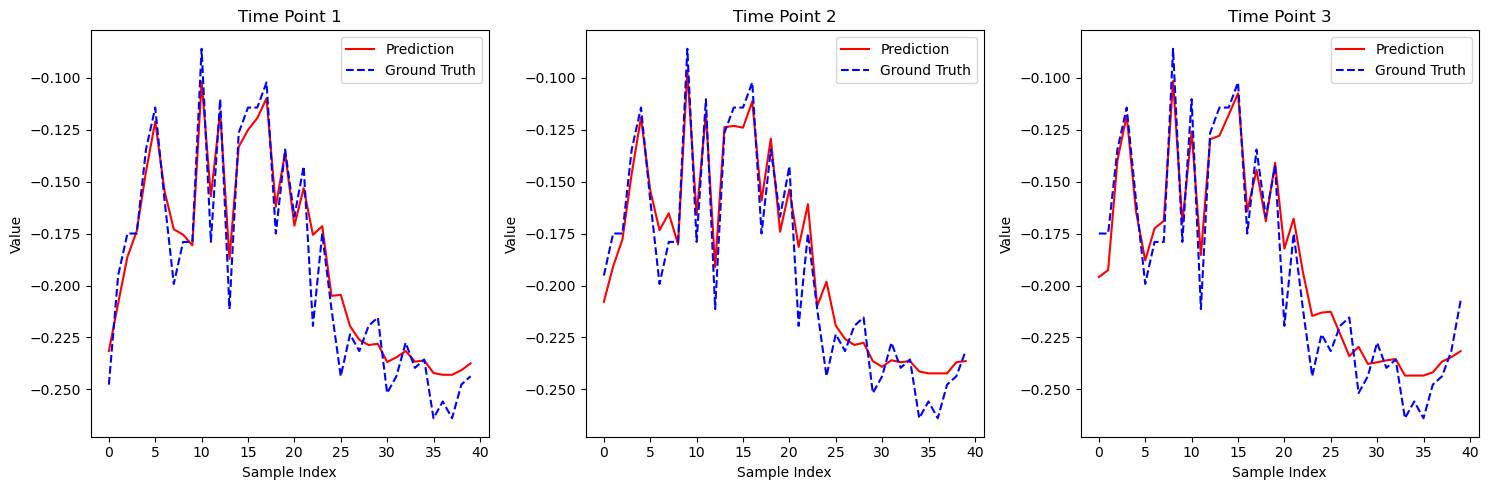

In [8]:
num_samples = 40  # Number of samples to display
time_points = 3  # Each sample predicts the next 3 time points

plt.figure(figsize=(15, 5))
for t in range(time_points):
    plt.subplot(1, 3, t + 1)
    
    # Gather all predictions and actual values for the t-th future time point across the first 40 samples
    predictions = out[:num_samples, t]
    truths = train_target[:num_samples, t]

    # Plotting the predictions and ground truth values
    plt.plot(range(num_samples), predictions.numpy(), 'r-', label='Prediction')
    plt.plot(range(num_samples), truths.numpy(), 'b--', label='Ground Truth')
    plt.title(f"Time Point {t + 1}")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.show()